In [21]:
!pip install lightgbm

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from collections import Counter
import shap
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [23]:
train = pd.read_csv('fraudTrain.csv', nrows=10000)

In [24]:
print(train.dtypes)

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


In [25]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [26]:
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'], errors='coerce')

# Extract useful numeric features from timestamp
train['year'] = train['trans_date_trans_time'].dt.year
train['month'] = train['trans_date_trans_time'].dt.month
train['day'] = train['trans_date_trans_time'].dt.day
train['hour'] = train['trans_date_trans_time'].dt.hour

# Drop the original timestamp column
train.drop('trans_date_trans_time', axis=1, inplace=True)

In [27]:
train['dob'] = pd.to_datetime(train['dob'], errors='coerce')
train['age'] = (pd.to_datetime('today') - train['dob']).dt.days // 365
train.drop('dob', axis=1, inplace=True)


In [28]:
columns_to_keep = ['age', 'hour', 'job', 'amt', 'is_fraud']
train = train[columns_to_keep]

In [29]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
categorical_columns = ['job']
for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col])


In [30]:
print(train.dtypes)

age           int64
hour          int32
job           int64
amt         float64
is_fraud      int64
dtype: object


In [31]:
labels=["Genuine","Fraud"]

fraud_or_not = train["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=train['is_fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()


/var/folders/40/pd7_rj613v51mh26flwsrdqm0000gn/T/ipykernel_23196/2838595709.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




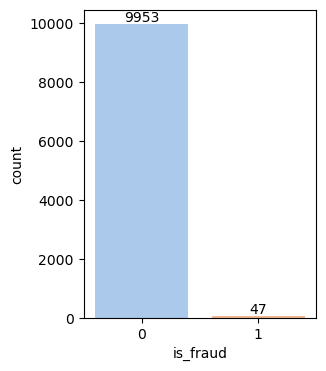

In [32]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='is_fraud',data=train,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [33]:
print('Genuine:', round(train['is_fraud'].value_counts()[0]/len(train) * 100,2), '% of the dataset')
print('Frauds:', round(train['is_fraud'].value_counts()[1]/len(train) * 100,2), '% of the dataset')

Genuine: 99.53 % of the dataset
Frauds: 0.47 % of the dataset


In [34]:
df = train.copy()

df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")

Duplicated values dropped succesfully


In [35]:
df.head()

,age,hour,job,amt,is_fraud
0,36,0,356,4.97,0
1,46,0,411,107.23,0
2,62,0,294,220.11,0
3,57,0,315,45.00,0
4,38,0,110,41.96,0


In [36]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [38]:
model_gb = lgb.LGBMClassifier(boosting_type='gbdt') # instantiate
model_gb.fit(X_train, y_train) # train

model_rf = lgb.LGBMClassifier(boosting_type='rf', bagging_fraction=0.8, feature_fraction=0.8) # instantiate
model_rf.fit(X_train, y_train) # train

model_drt = lgb.LGBMClassifier(boosting_type='dart') # instantiate
model_drt.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 33, number of negative: 6966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004715 -> initscore=-5.352289
[LightGBM] [Info] Start training from score -5.352289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(boosting_type='dart')

In [39]:
y_pred_gb = model_gb.predict(X_test) # creating prediction with model and test data (from split earlier)
y_pred_rf = model_rf.predict(X_test) # creating prediction with model and test data (from split earlier)
y_pred_drt = model_drt.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [40]:
accuracy_gb = accuracy_score(y_test, y_pred_gb) # accuracy score


# confusion matrix essential shows a matrix of model output vs actual. there are 4 possibilities:
# 2 are when the model outputs correctly (actual = expected)
# 2 are when the model outputs incorrectly (actual != expected)
# these are called errors and there are type 1 errors and type 2 errors
# errors where the model predicts 0 and actual is 1 is a type 1 error (false negative). this is dangerous in certain cases such as if the model
# is dealing with humans, e.g. predicting cancer diagnosis, pretty fucked up if model says ur not sick and u lose ur hair a week later
# type 2 error (false positive) vice versa, in some cases it's not bad but the consequences are usually just lost capital
# (spending time and money fixing a non-existent problem)
# these cases are important to look at regarding your dataset and the problem you are trying to solve


conf_matrix_gb = confusion_matrix(y_test, y_pred_gb) # confusion matrix
norm_conf_matrix_gb = confusion_matrix(y_test,y_pred_gb,normalize='true') # normal confusion matrix

accuracy_gb

0.9986666666666667

In [41]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
norm_conf_matrix_rf = confusion_matrix(y_test,y_pred_rf,normalize='true')

accuracy_rf

0.9743333333333334

In [42]:
accuracy_drt = accuracy_score(y_test, y_pred_drt)

conf_matrix_drt = confusion_matrix(y_test, y_pred_drt)
norm_conf_matrix_drt = confusion_matrix(y_test,y_pred_drt,normalize='true')

accuracy_drt

0.998

<function matplotlib.pyplot.show(close=None, block=None)>

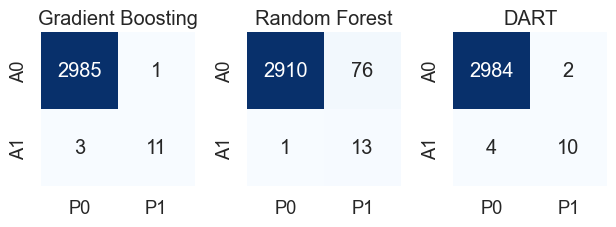

In [43]:
sns.set(font_scale=1.2)

plt.subplot(1,3,1) #creating a plot of plots, showing the plots side by side (matplotlib bullshit)

# Create a heatmap of the confusion matrix (essentially visualize the matrix we made earlier so it's not just an array)
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["P0", "P1"],
            yticklabels=["A0", "A1"])

# Add labels and a title

plt.title('Gradient Boosting')

plt.subplot(1,3,2)

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["P0", "P1"],
            yticklabels=["A0", "A1"])

# Add labels and a title

plt.title('Random Forest')

plt.subplot(1,3,3)

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix_drt, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["P0", "P1"],
            yticklabels=["A0", "A1"])

# Add labels and a title

plt.title('DART')

plt.tight_layout()
plt.show

<Axes: title={'center': 'DART'}, xlabel='Feature importance', ylabel='Features'>

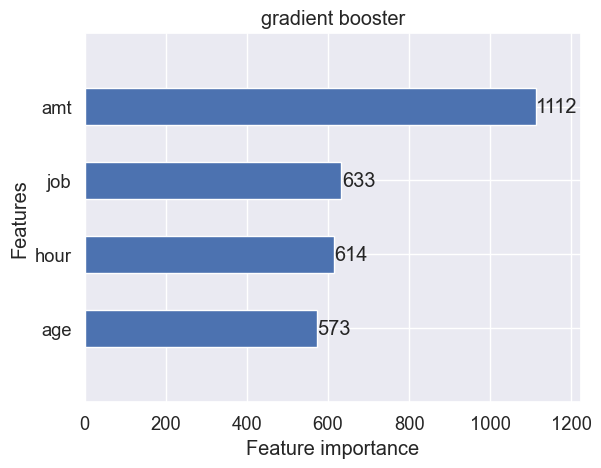

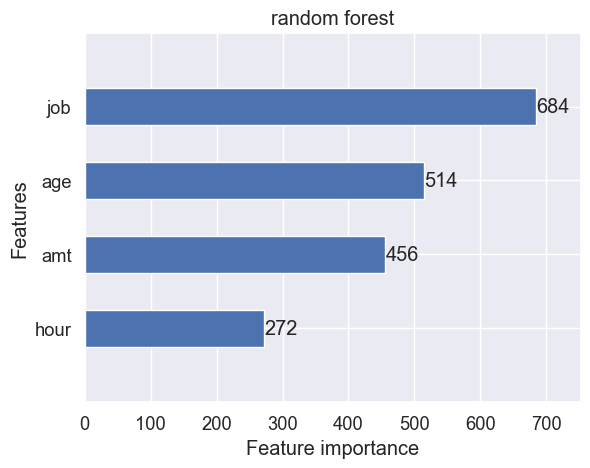

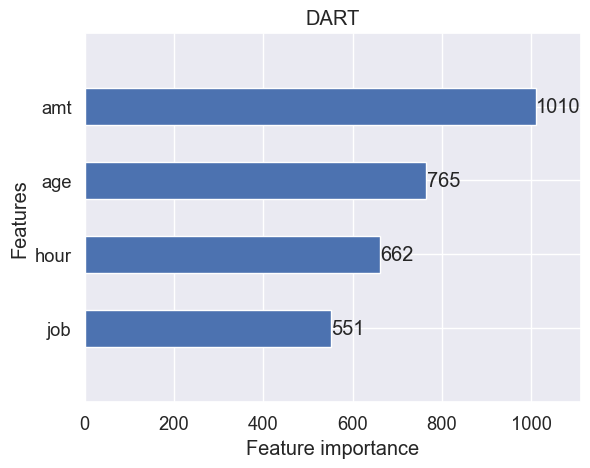

In [44]:
lgb.plot_importance(model_gb, height = 0.5, title = "gradient booster")
lgb.plot_importance(model_rf, height = 0.5, title="random forest")
lgb.plot_importance(model_drt, height = 0.5, title='DART')

In [45]:
explainer_new_gb = shap.Explainer(model_gb, X)
new_shap_values_gb = explainer_new_gb(X)

 96%|=================== | 9633/9999 [00:23<00:00]       

In [46]:
explainer_new_rf = shap.Explainer(model_rf, X)
new_shap_values_rf = explainer_new_rf(X)

 95%|=================== | 9505/9999 [00:11<00:00]       

In [47]:
explainer_new_drt = shap.Explainer(model_drt, X)
new_shap_values_drt = explainer_new_drt(X)

 96%|=================== | 9562/9999 [00:17<00:00]       

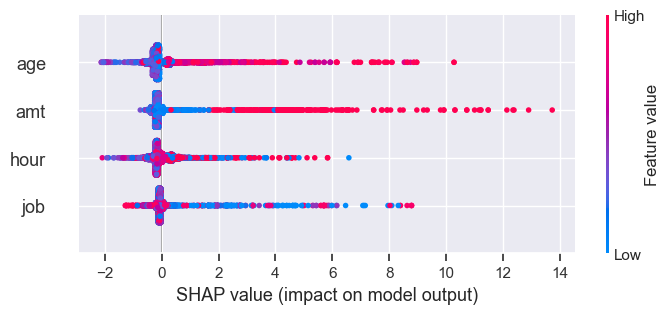

In [48]:
shap.plots.beeswarm(new_shap_values_gb)

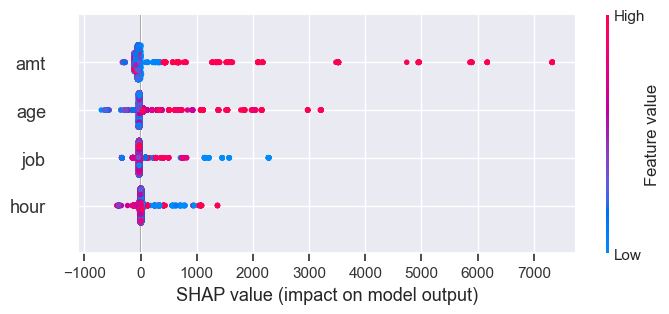

In [49]:
shap.plots.beeswarm(new_shap_values_rf)

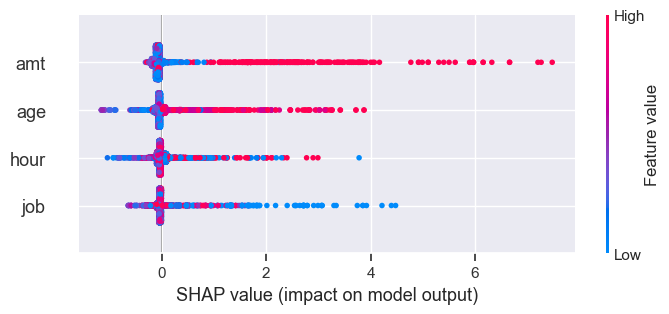

In [50]:
shap.plots.beeswarm(new_shap_values_drt)


In [51]:
model_gb.booster_.save_model('mode.txt')
#load from model:

bst = lgb.Booster(model_file='mode.txt')
